# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](Images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
from ipywidgets import *
from IPython.display import display
import pandas as pd
from IPython.display import display, HTML
from tqdm import tqdm
import numpy as np
from glob import glob
from enum import Enum
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
from torchvision import datasets,transforms
from PIL import ImageFile
import math
import random
import helpers as hlp
import models as mds
import time
import copy

In [2]:

# load filenames for human and dog images
human_files = np.array(glob("data/lfw/*/*"))
dog_files = np.array(glob("data/dogImages_crop_350/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


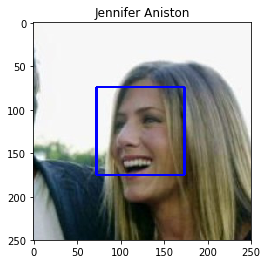

In [11]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
filename = human_files[random.randint(0,len(human_files)-1)]
img = cv2.imread(filename)

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# display the image, along with bounding box
plt.imshow(cv_rgb)
name = hlp.get_name_from_filename(filename)
plt.title(name)
plt.show()

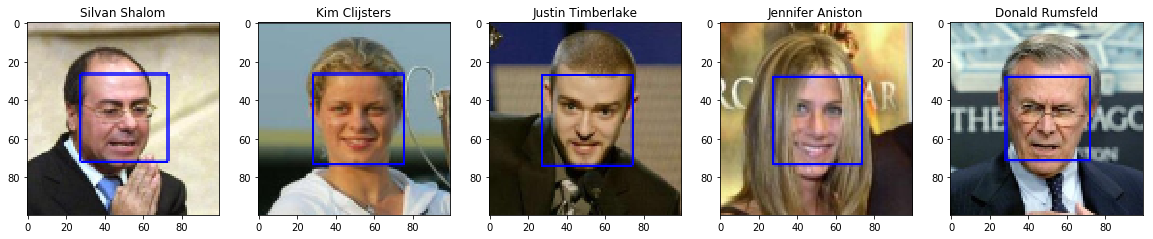

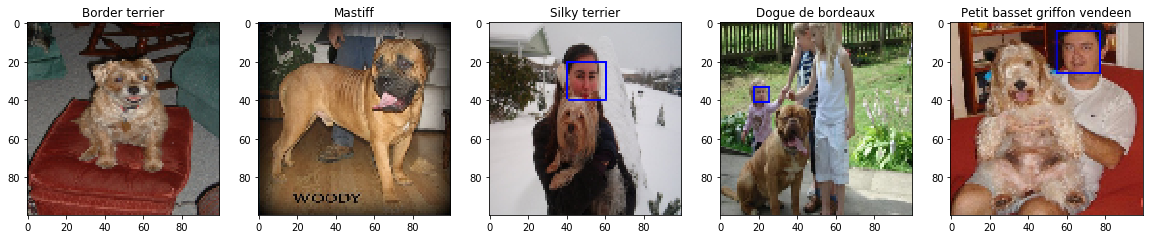

In [24]:
samples = random.sample(range(0, len(human_files)-1), 5)
sample_files = human_files[samples]
hlp.show_images(image_files = sample_files, n_col = 5, image_size = 200, h = 20, w = 20)

samples = random.sample(range(0, len(dog_files)-1), 5)
sample_files = dog_files[samples]
hlp.show_images(image_files = sample_files, n_col = 5, image_size = 200, h = 20, w = 20)

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

- `99.0%` human faces detected using face-detector with 1 exception
- `8.0%` dogs detected with human faces using face-detector

Accuracy | F1-score 
-------- | --------
0.925 | 0.93

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## on the images in human_files_short and dog_files_short.

def display_performance(TP, FN, TN, FP):
    # computing acccuracy and f1-score
    precision=TP/(FP+TP)
    recall=TP/(FN+TP)
    accuracy=(TP+TN)/(TP+TN+FP+FN)
    f1score=2*((precision*recall)/(precision+recall))
    print('---------------------')
    print('| Accuracy | {}|'.format(str(round(accuracy,3 ) ).rjust(7) ))
    print('---------------------')
    print('| F1-score | {}|'.format(str(round(f1score,3 ) ).rjust(7) ))
    print('---------------------')
    
def eval_detector(sample_files, detector, positive):
    """
    parameters:
        sample_files: list of image file names to be detected
        detector: Is a detector function i.e can be face detector or dog detector
    """
    
    positive_files = []
    negative_files = []
    for file_path in tqdm(sample_files):
        detected = detector(file_path) 
        if detected:
            positive_files.append(file_path)
        else:
            negative_files.append(file_path)
            
    if positive:        
        TP = len(positive_files)
        FN = len(negative_files)
        TN = None
        FP = None
    else:
        TP = None
        FN = None
        TN = len(negative_files)
        FP = len(positive_files)
        
    return positive_files, negative_files, TP, FN, TN, FP

### Evaluate human face detector

100%|██████████| 100/100 [00:07<00:00, 12.82it/s]


--------------------------------------------------
99.000% human faces detected with 1 exception
--------------------------------------------------


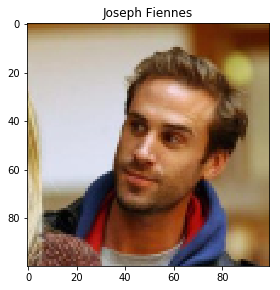

100%|██████████| 100/100 [00:13<00:00,  7.11it/s]


--------------------------------------------------
14.000% dogs detected with human faces
--------------------------------------------------


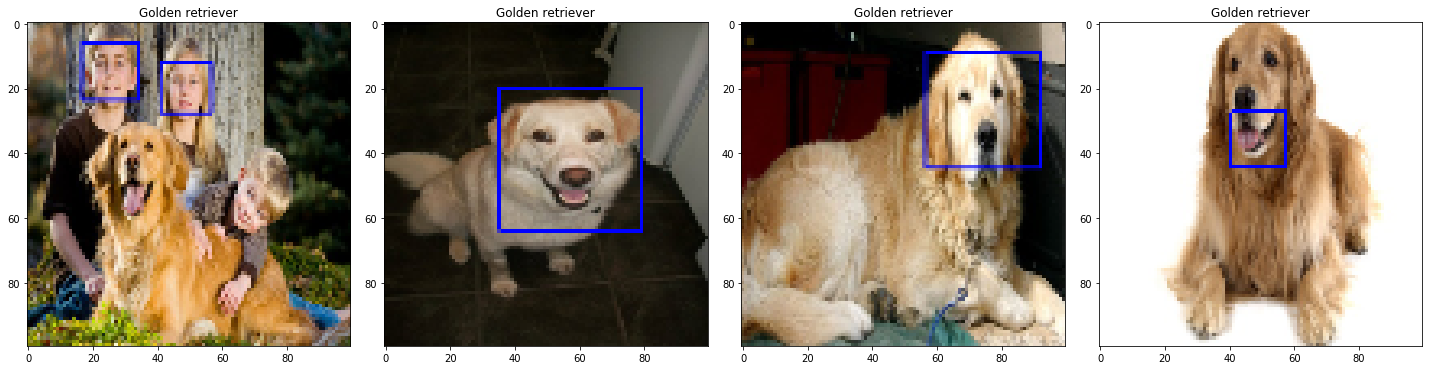

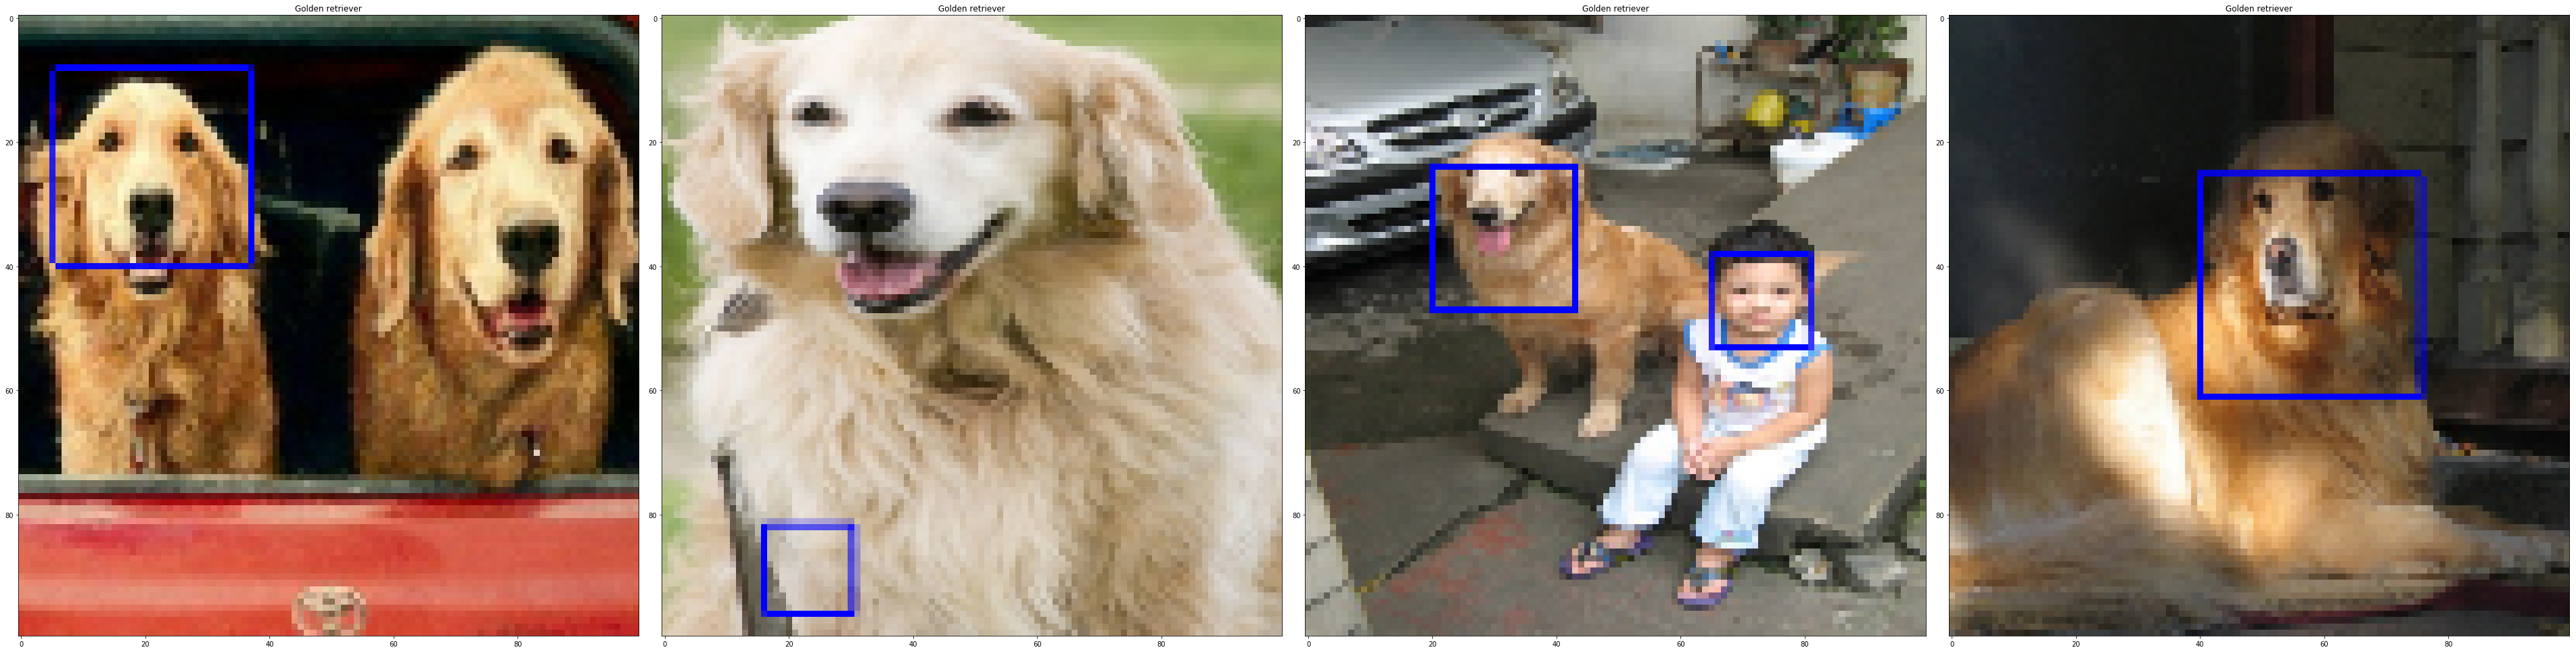

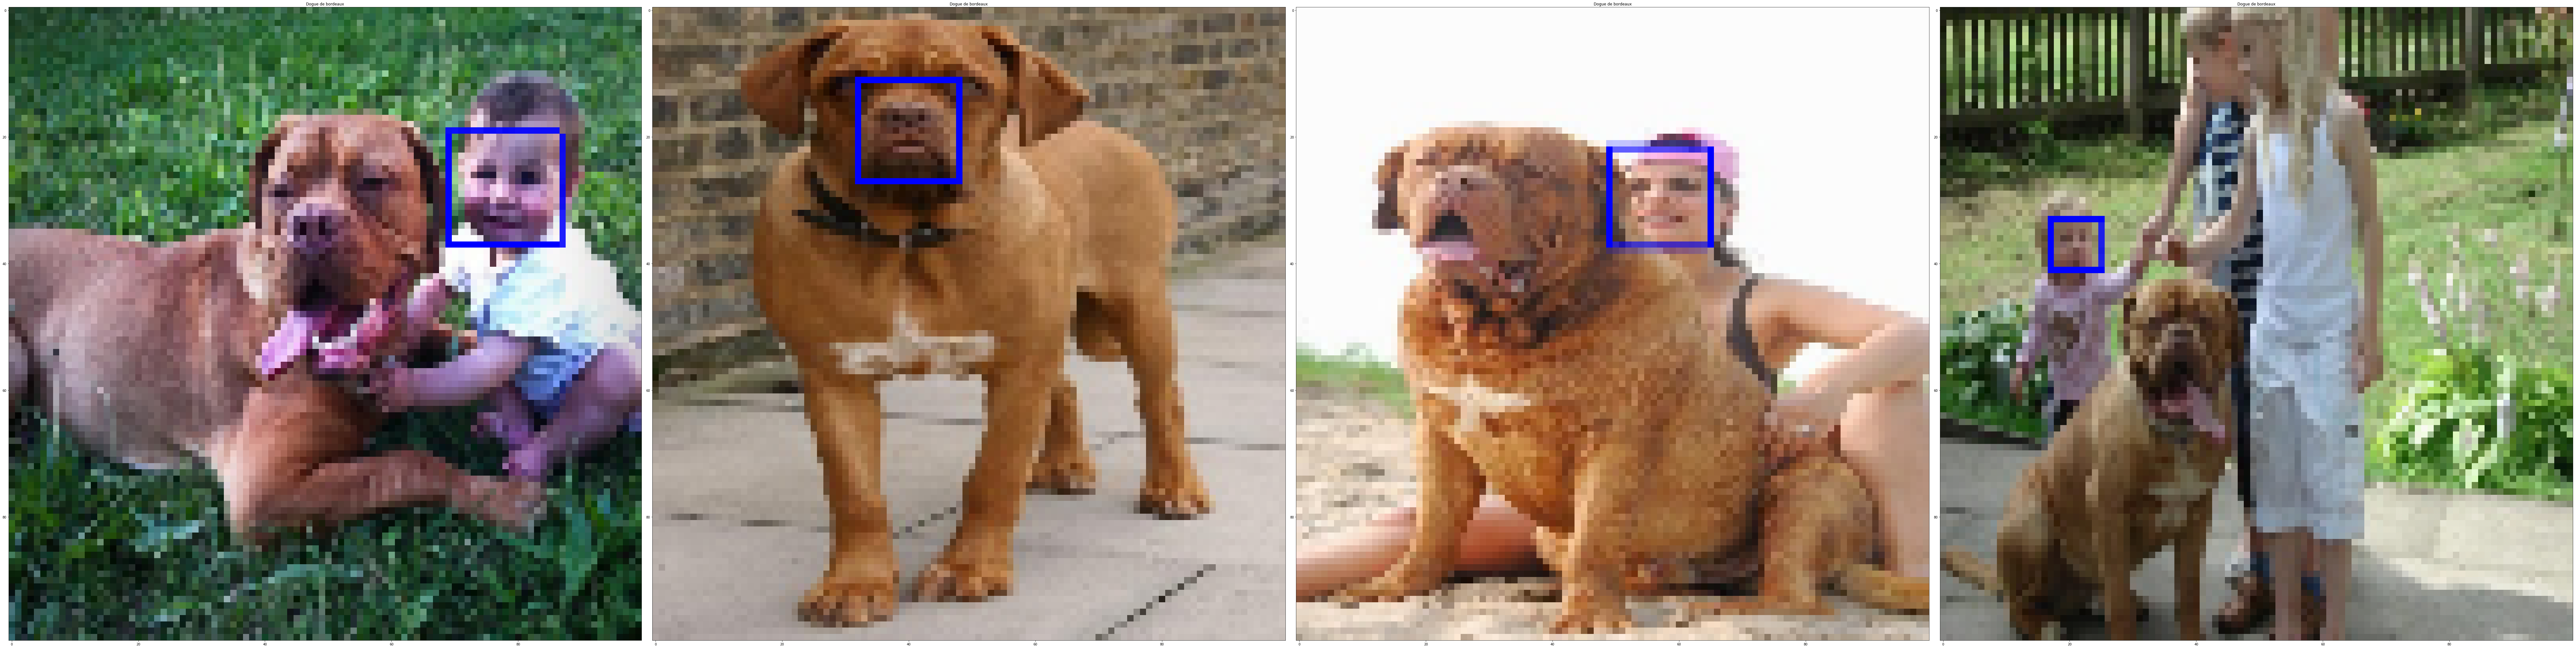

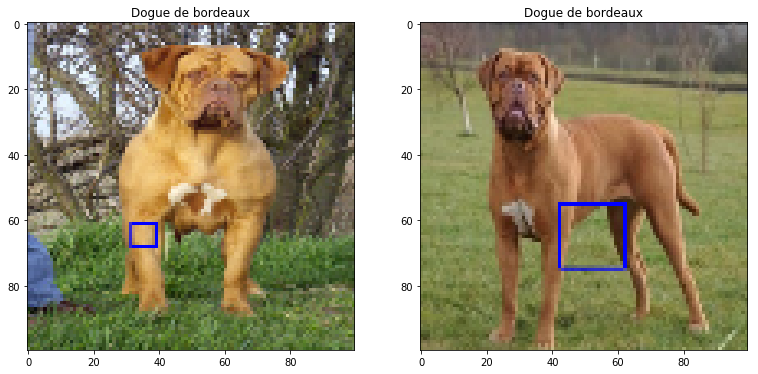

---------------------
| Accuracy |   0.925|
---------------------
| F1-score |    0.93|
---------------------


In [7]:
# detect human face in human_files_short images
human_face, no_human_face, TP, FN,_,_ = eval_detector(human_files_short, face_detector, positive=True)
print('-'*50)
print('{:.3f}% human faces detected with {} exception'.format((TP)/(FN+TP)*100, FN))
print('-'*50)
hlp.show_images(image_files = no_human_face, n_col = 4, image_size = 50, h = 20, w = 20)
plt.show();

# detect human face in dog_files_short images
human_face_in_dog, no_human_face_in_dog, _, _, TN, FP = eval_detector(dog_files_short, face_detector, positive=False)
print('-'*50)
print('{:.3f}% dogs detected with human faces'.format(((FP)/(FP+TN)*100)))
print('-'*50)
hlp.show_images(image_files = human_face_in_dog, n_col = 4, image_size = 50, h = 20, w = 20)
plt.show();

display_performance(TP, FN, TN, FP)

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [8]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 118946876.38it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

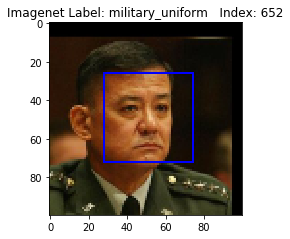

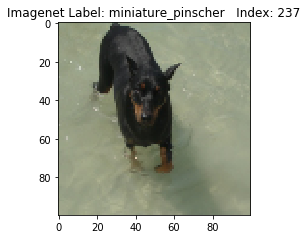

In [7]:
from PIL import Image
import torchvision.transforms as transforms
import json

def load_image(img_path, size=[224, 224]):
    
    image = Image.open(img_path).convert('RGB')
    
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    #load and transform image
    Image = load_image(img_path)
    
    #predict using pre-trained VGG16 model
    prediction = VGG16(Image)
    
    #Get index
    index = prediction.data.numpy().argmax() 
    
    return index # predicted class index

def get_imagenet_class_label(index):
    
    class_idx = json.load(open("imagenet_class_index.json"))
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    return idx2label[index]

human_idx = random.randint(0, len(human_files)-1)
index_human = VGG16_predict(human_files[human_idx])

dog_idx = random.randint(0, len(dog_files)-1)
index_dog = VGG16_predict(dog_files[dog_idx])


sample_files = [human_files[human_idx]]
titles=['Imagenet Label: {}   Index: {}'.format(get_imagenet_class_label(index_human), index_human)]
hlp.show_images(image_files = sample_files, n_col = 5, image_size = 200, h = 20, w = 20, titles=titles)
plt.show()

sample_files = [dog_files[dog_idx]]
titles=['Imagenet Label: {}   Index: {}'.format(get_imagenet_class_label(index_dog), index_dog)]
hlp.show_images(image_files = sample_files, n_col = 5, image_size = 200, h = 20, w = 20, titles=titles)
plt.show()

In [9]:
def predict_imagenet_class_label(img_path):
    imagenet_class_index = VGG16_predict(img_path)
    return get_imagenet_class_label(imagenet_class_index)

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    prediction = VGG16_predict(img_path)
    return prediction>=151 and prediction<=268

print('Test- human_files[0] prediction: ',dog_detector(human_files[0]))
print('Test- dog_files[0] prediction: ',dog_detector(dog_files[0]))

Test- human_files[0] prediction:  False
Test- dog_files[0] prediction:  True


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- `2.0%` dogs detected in human faces using VGG-16 dog-detector
- `100.0%` dogs correctly detected with 0 exception using VGG-16 dog-detector

Accuracy | F1-score 
-------- | --------
0.995 | 0.995

  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------
100.0% dogs correctly detected with 0 exception
--------------------------------------------------


100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


--------------------------------------------------
1.0% dogs detected in human faces
--------------------------------------------------


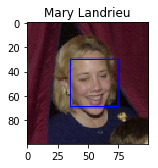

---------------------
| Accuracy |   0.995|
---------------------
| F1-score |   0.995|
---------------------


In [9]:
### on the images in human_files_short and dog_files_short.

# Detect dogs in dog_files_short
dogs_detected, dogs_not_detected, TP, FN,_,_ = eval_detector(dog_files_short, dog_detector, positive=True)
print('-'*50)
print('{}% dogs correctly detected with {} exception'.format((TP)/(FN+TP)*100, FN))
print('-'*50)
hlp.show_images(image_files = dogs_not_detected, n_col = 4, image_size = 50, h = 10, w = 10)
plt.show();

# Detect dogs in human_files_short
dogs_detected_in_faces, no_dogs_detected_in_faces, _, _, TN, FP = eval_detector(human_files_short, dog_detector, positive=False)
print('-'*50)
print('{}% dogs detected in human faces'.format(((FP)/(FP+TN)*100)))
print('-'*50)
hlp.show_images(image_files = dogs_detected_in_faces, n_col = 4, image_size = 50, h = 10, w = 10)
plt.show();

display_performance(TP, FN, TN, FP)

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [13]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="Images/Brittany_02625.jpg" width="100"> | <img src="Images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
---------------------- | ----------------------
<img src="Images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="Images/American_water_spaniel_00648.jpg" width="200">

Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
--------------- | ------------------ | --------------
<img src="Images/Labrador_retriever_06457.jpg" width="150"> | <img src="Images/Labrador_retriever_06455.jpg" width="230"> | <img src="Images/Labrador_retriever_06449.jpg" width="200">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

## Default values

In [11]:
batch_size = 20
image_size = 315
base_lr = 0.0065 # used by get_triangular_lr for generating learning rate
max_lr = 0.004 # used by get_triangular_lr for generating learning rate
optim_type = 'Adam'
model_scratch_save_path = 'model_scratch.pt'

## Load and transform Data

*Following are functions for finding and handling class imbalance, if it exist.* 

*`get_class_info` returns indexes of classes with minimum and maximum count.*

*`create_weighted_random_sampler` creates a `WeightedRandomSampler` which can be passed as `sampler=WeightedRandomSampler` to `DataLoader` when there is a class imbalance.*

*`get_class_weights` returns class_weights, which is then passed to **`CrossEntropy`**. This option can also be used during class imbalance *

In [12]:
def get_class_info(data):
    
    classes = len(data.classes)
    
    samples={}
    samples = dict(collections.Counter(sample_tup[1] for sample_tup in data.imgs))
    sorted_x = sorted(samples.items(), key=operator.itemgetter(1))
    
    min_class_idx = sorted_x[0][0]
    n_min_class = sorted_x[0][1]
    
    max_class_idx = sorted_x[classes-1][0]
    n_max_class = sorted_x[classes-1][1]
    
    return min_class_idx, n_min_class, max_class_idx, n_max_class

def get_sample_counts(data):
    samples = dict(collections.Counter(sample_tup[1] for sample_tup in data.imgs))
    return list(val for val in samples.values())

# below function creates WeightedRandomSampler
if torch.__version__ == '1.0.0':
    from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader
    def create_weighted_random_sampler(data, replacement = True):
        
        class_sample_counts = get_sample_counts(data)

        weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)

        sample_targets = list(sample_tup[1] for sample_tup in data_scratch['train'].imgs)

        samples_weights = weights[sample_targets]

        return WeightedRandomSampler( weights=samples_weights, num_samples=len(samples_weights), replacement=replacement)

# below function creates class_weights to be passed to CrossEntropty
def get_class_weights(data):
    
    class_sample_counts = get_sample_counts(data)

    class_weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
    
    return class_weights

*Follwoing function return's 3 different types of transformations. `None` is used by `valid` and `test` loaders, while `'Default` is used by `train` loader. `'Visualize'` is same as `Default` type, except it does not add `ToTensor` and `Normalize` transformation.*

In [13]:
def get_image_transforms(image_size, trans_type='Default'):
    
    # Valid trans_type
    assert trans_type==None or trans_type =='Default' or trans_type == 'Visualize'
    
    # Crop size
    out_size = math.floor(image_size*0.9)
    
    img_transforms=[]
    
    if trans_type=='Default' or trans_type=='Visualize':
        img_transforms.append(transforms.RandomHorizontalFlip())
        img_transforms.append(transforms.RandomRotation(30))
        img_transforms.append(transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1))
        img_transforms.append(transforms.RandomGrayscale(p=0.4))
        img_transforms.append(transforms.RandomResizedCrop(out_size, scale=(0.08,1), ratio=(1,1)))
    else:
        img_transforms.append(transforms.CenterCrop(out_size))
    
    if not trans_type=='Visualize':
        img_transforms.append(transforms.ToTensor())
        img_transforms.append(transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)))
    
    return img_transforms

*`load_images` funtion creates 3 DataLoader i.e. train/valid/test for image transformations during learning and testing phase.* 

In [14]:
import os
import torch
from torchvision import datasets,transforms
from PIL import ImageFile
import collections
import operator

ImageFile.LOAD_TRUNCATED_IMAGES = True

## Specify appropriate transforms, and batch_sizes

def load_images(num_workers=0, batch_size=batch_size, image_size = image_size, trans_type='Default'):
    data_dir = 'data/dogImages_crop_350/'
    train_dir = os.path.join(data_dir, 'train/')
    valid_dir = os.path.join(data_dir, 'valid/')
    test_dir = os.path.join(data_dir, 'test/')
    
    # load and transform data using ImageFolder
    
    train_transforms = get_image_transforms(image_size, trans_type)
    data_train_transform = transforms.Compose(np.array(train_transforms))
    
    none_transforms = get_image_transforms(image_size, trans_type=None)
    data_none_transform = transforms.Compose(np.array(none_transforms))

    train_data = datasets.ImageFolder(train_dir, transform=data_train_transform)
    valid_data = datasets.ImageFolder(valid_dir, transform=data_none_transform)
    test_data = datasets.ImageFolder(test_dir, transform=data_none_transform)
    
    min_class_idx, n_min_class, max_class_idx, n_max_class = get_class_info(train_data)
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,\
                                             num_workers=num_workers)

    validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)

    testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
    
    data_scratch = dict(train=train_data, valid=valid_data,  test=test_data)
    loaders_scratch = dict(train=trainloader, valid=validloader,  test=testloader)
    return data_scratch, loaders_scratch, min_class_idx, n_min_class, max_class_idx, n_max_class


data_scratch, loaders_scratch, min_class_idx, n_min_class, max_class_idx, n_max_class = load_images()
use_cuda = torch.cuda.is_available()
n_classes = len(data_scratch['train'].classes)
# print out some data stats
print('No# training images: ', len(data_scratch['train']))
print('No# validation images: ', len(data_scratch['valid']))
print('No# test images: ', len(data_scratch['test']))
print('No# test classes: ', n_classes)
print('Cuda enabled:', use_cuda)

if n_min_class == n_max_class:
    print('\nSamples in each class: {}'.format(n_min_class))
else:
    print('\nClass with minimum samples:- {}({} samples)'.format(data_scratch['train'].classes[min_class_idx], n_min_class))
    print('Class with maximum samples:- {}({} samples)'.format(data_scratch['train'].classes[max_class_idx], \
                                                               n_max_class))

No# training images:  6680
No# validation images:  835
No# test images:  836
No# test classes:  133
Cuda enabled: False

Class with minimum samples:- 108.Norwegian_buhund(26 samples)
Class with maximum samples:- 005.Alaskan_malamute(77 samples)


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


# **Answer**:

Applied Data augmentation using `torchvision`, as details are mentioned below. The model starts overfitting after `3rd epoch`, if augmentation is not applied.

- **Data augmentation using `cv2`:** 
  - Below augmenation applied on training data before being fed to the model:
     - `Resized` the images to 350 x 350. Preserved the aspect ration while resizing
     - `CentreCrop` of size (315) x (315) i.e. 350x0.9=315
  
  - Using `cv2`, resized and croped the image files to 315x315 during testings. Also it reduced the zip size to `358 MB` from `1.05 GB`



- **Data augmentation using `torchvision`:** 
  - Following augmenation applied on training data:
     - RandomHorizontalFlip()
     - RandomRotation(30)
     - ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
     - RandomGrayscale(p=0.4)
     - RandomResizedCrop(`283`, scale=(0.08,1), ratio=(1,1))
     - Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
     
     
  - Following augmenation applied on validation and test data:
     - CenterCrop(`283`)
     - Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
     
     
     
- Input size to Model ***`283x283`*** i.e. *`315 x 0.9=283`* [ `0.9` is the ratio for cropping]. The image gets cropped twice, i.e once during *resize* and *CenterCrop* transformation (size: from `350x350` to `315x315`) using *cv2* and next in *RandomResizedCrop* (size: from `315x315` to `283 x283`) during training using *torchvision*.



- Reason to use a slightly larger input size (i.e 283) compared to other well known pre-trained networks was,
  - To increase number of parameters given to the `AdaptiveAvgPool2d(output_size=8)`. If input size is 268x268, then input to `AdaptiveAvgPool2d` is 9x9, where as for input size 283x283 to network, the input to `AdaptiveAvgPool2d` is 10x10
  - Also not using a larger size than 350x350 was to avoid memory issues.
  
  
  
- There is a class imbalance in dataset, *i.e.* ***Norwegian buhund*** class has ***26*** samples while ***Alaskan malamute*** has ***77*** samples. Using pytorch, there are 2 approaches to handle class imbalance:

  - 1. We can use `WeightedRandomSampler` and assign it to `sampler` in **dataloader**. ***But works on version 1.0.0 and above.

        - ref: https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703/3*

        - ref: https://discuss.pytorch.org/t/some-problems-with-weightedrandomsampler/23242*
        
  - 2. We can also assign class `weights` to `CrossEntropyLoss` i.e. assign large weight to under-sampled classes and less weight to over-sampled classes
  
        - ref: https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss
        
    *[Used 2nd option for class imbalance during testing. But didn't see any performance gain. Also saw increase in loss and processing time.]*

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [15]:
"""  F I N A L  M O D E L  from Test-7 [Also defined in models.py]"""
class Net(nn.Module):
    # same as Net_3 except for in_features
    def __init__(self):
        super().__init__()
        
        #self.max_pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2d1_1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 1, bias=False)
        self.pool1_1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2d1_2 = nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1,bias=False)
        self.pool1_2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.BatchNorm2d1 = nn.BatchNorm2d(32)
        self.LeakyReLU1 = nn.LeakyReLU(negative_slope=0.1)
        
        self.conv2d2_1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, bias=False)
        self.pool2_1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2d2_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1,bias=False)
        self.pool2_2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.BatchNorm2d2 = nn.BatchNorm2d(64)
        self.LeakyReLU2 = nn.LeakyReLU(negative_slope=0.1)
        
        self.conv2d3_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, bias=False)
        self.pool3_1 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.conv2d3_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1,bias=False)
        self.pool3_2 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.BatchNorm2d3 = nn.BatchNorm2d(128)
        self.LeakyReLU3 = nn.LeakyReLU(negative_slope=0.1)
        
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=8)
        
        self.fc1 = nn.Linear(in_features=8192, out_features=1024, bias=False)
        self.fc1_bn1d = nn.BatchNorm1d(1024)
        self.fc1_relu = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features=1024, out_features=n_classes, bias=False)
        self.fc2_bn1d = nn.BatchNorm1d(n_classes)
        
    def forward(self, x):
        
        x = self.LeakyReLU1(self.BatchNorm2d1(self.pool1_2(self.conv2d1_2(self.pool1_1(self.conv2d1_1(x))))))
        
        x = self.LeakyReLU2(self.BatchNorm2d2(self.pool2_2(self.conv2d2_2(self.pool2_1(self.conv2d2_1(x))))))
        
        x = self.LeakyReLU3(self.BatchNorm2d3(self.pool3_2(self.conv2d3_2(self.pool3_1(self.conv2d3_1(x))))))
        
        x = self.avg_pool(x)
        
        x = x.view(-1, 8192)
        
        x = self.fc1_relu(self.fc1_bn1d( self.fc1( x ) ) )
        
        x = self.fc2_bn1d( self.fc2( x ) ) 
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

""" instantiate the CNN """
model_scratch = Net()

""" move tensors to GPU if CUDA is available """ 

if use_cuda:
    model_scratch.cuda()

### Weight initialization
* *ref. 1:* https://www.youtube.com/watch?v=s2coXdufOzE
* *ref. 2:* https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L112-L118
* *ref. 3:* https://pytorch.org/docs/stable/nn.html



In [16]:
def weights_init(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
model_scratch.apply(weights_init)

Net(
  (conv2d1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (pool1_1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool1_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (BatchNorm2d1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyReLU1): LeakyReLU(negative_slope=0.1)
  (conv2d2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (pool2_1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool2_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (BatchNorm2d2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyReLU2): LeakyReLU(negative_slope=0.1)
  (conv2d3_1): C

### Visualizing feature maps

- Below function shows the image transformation steps applied by torchvision during training.
- Also below we can see, randomly selected  feature maps generated by convolutional layer

Original image size:  (315, 315, 3)


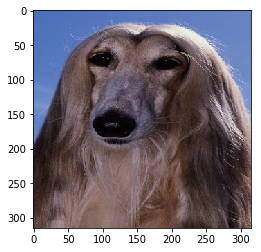

-------------------------------------------------------------------------------------------------------------------------------
transform: RandomHorizontalFlip(p=0.5)  
image size: (315, 315, 3)  time: 0.00026702880859375
-------------------------------------------------------------------------------------------------------------------------------


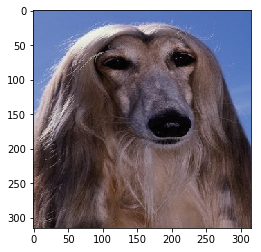

-------------------------------------------------------------------------------------------------------------------------------
transform: RandomRotation(degrees=(-30, 30), resample=False, expand=False)  
image size: (315, 315, 3)  time: 0.0007410049438476562
-------------------------------------------------------------------------------------------------------------------------------


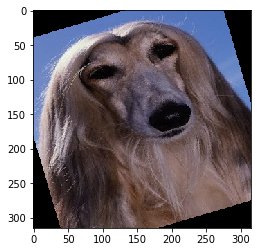

-------------------------------------------------------------------------------------------------------------------------------
transform: ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)  
image size: (315, 315, 3)  time: 0.018306970596313477
-------------------------------------------------------------------------------------------------------------------------------


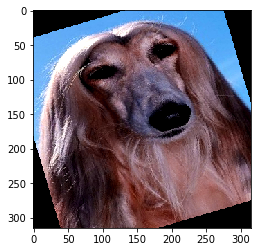

-------------------------------------------------------------------------------------------------------------------------------
transform: RandomGrayscale(p=0.4)  
image size: (315, 315, 3)  time: 0.0016679763793945312
-------------------------------------------------------------------------------------------------------------------------------


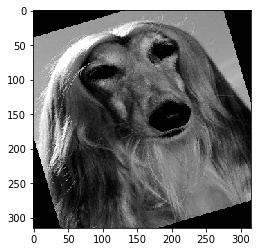

-------------------------------------------------------------------------------------------------------------------------------
transform: RandomResizedCrop(size=(283, 283), scale=(0.08, 1), ratio=(1, 1), interpolation=PIL.Image.BILINEAR)  
image size: (283, 283, 3)  time: 0.0032949447631835938
-------------------------------------------------------------------------------------------------------------------------------


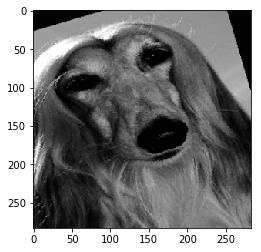

-------------------------------------------------------------------------------------------------------------------------------
Module: Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
Output size( 32x281x281 ): 2526752     Time: 0.011116504669189453
-------------------------------------------------------------------------------------------------------------------------------


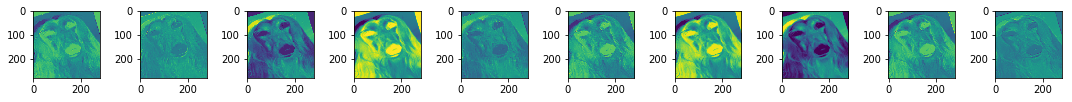

-------------------------------------------------------------------------------------------------------------------------------
Module: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Output size( 32x140x140 ): 627200     Time: 0.015166997909545898
-------------------------------------------------------------------------------------------------------------------------------


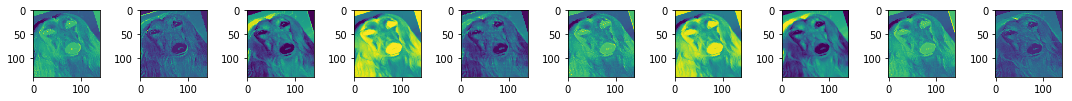

-------------------------------------------------------------------------------------------------------------------------------
Module: Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Output size( 32x140x140 ): 627200     Time: 0.02523207664489746
-------------------------------------------------------------------------------------------------------------------------------


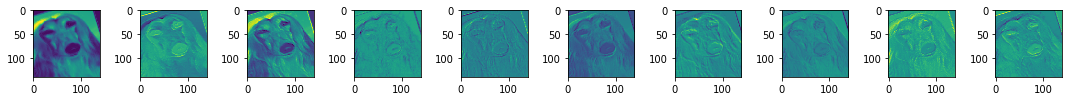

-------------------------------------------------------------------------------------------------------------------------------
Module: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Output size( 32x69x69 ): 152352     Time: 0.003282308578491211
-------------------------------------------------------------------------------------------------------------------------------


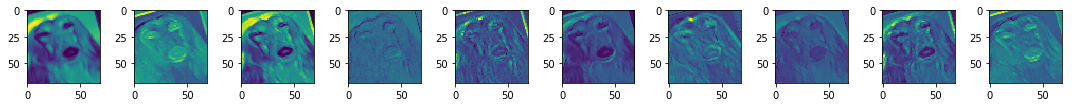

-------------------------------------------------------------------------------------------------------------------------------
Module: BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output size( 32x69x69 ): 152352     Time: 0.005103588104248047
-------------------------------------------------------------------------------------------------------------------------------


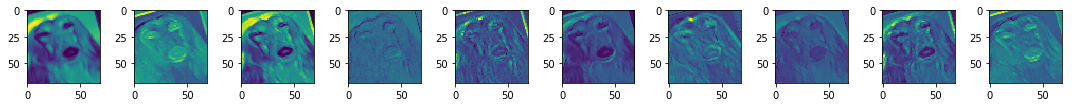

-------------------------------------------------------------------------------------------------------------------------------
Module: LeakyReLU(negative_slope=0.1)
Output size( 32x69x69 ): 152352     Time: 0.01394796371459961
-------------------------------------------------------------------------------------------------------------------------------


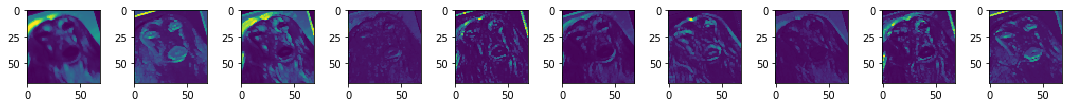

-------------------------------------------------------------------------------------------------------------------------------
Module: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
Output size( 64x67x67 ): 287296     Time: 0.009050369262695312
-------------------------------------------------------------------------------------------------------------------------------


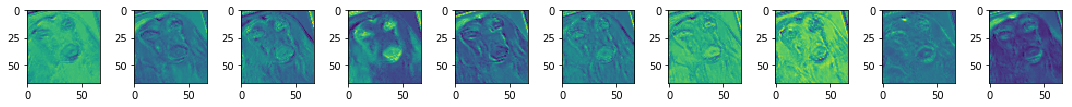

-------------------------------------------------------------------------------------------------------------------------------
Module: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Output size( 64x33x33 ): 69696     Time: 0.001703500747680664
-------------------------------------------------------------------------------------------------------------------------------


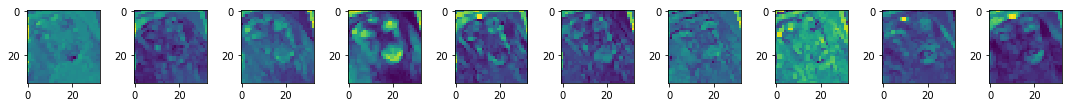

-------------------------------------------------------------------------------------------------------------------------------
Module: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Output size( 64x33x33 ): 69696     Time: 0.0046803951263427734
-------------------------------------------------------------------------------------------------------------------------------


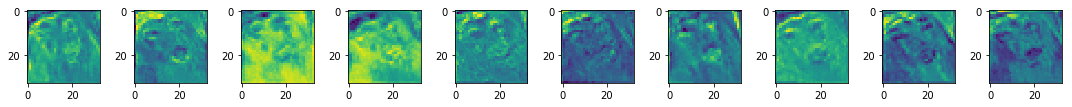

-------------------------------------------------------------------------------------------------------------------------------
Module: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Output size( 64x16x16 ): 16384     Time: 0.0005252361297607422
-------------------------------------------------------------------------------------------------------------------------------


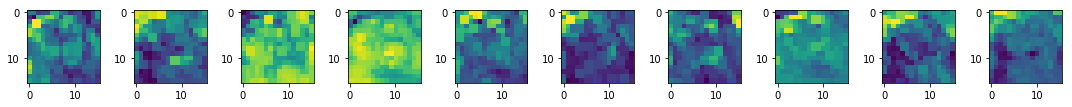

-------------------------------------------------------------------------------------------------------------------------------
Module: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output size( 64x16x16 ): 16384     Time: 0.00035953521728515625
-------------------------------------------------------------------------------------------------------------------------------


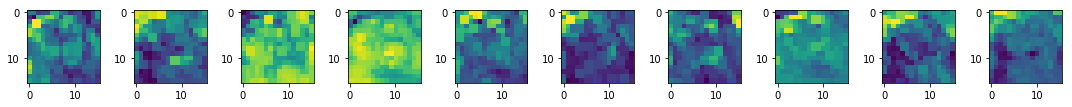

-------------------------------------------------------------------------------------------------------------------------------
Module: LeakyReLU(negative_slope=0.1)
Output size( 64x16x16 ): 16384     Time: 0.00017309188842773438
-------------------------------------------------------------------------------------------------------------------------------


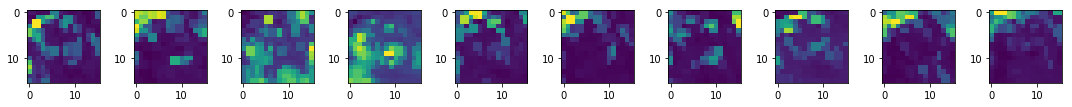

-------------------------------------------------------------------------------------------------------------------------------
Module: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
Output size( 128x14x14 ): 25088     Time: 0.0015189647674560547
-------------------------------------------------------------------------------------------------------------------------------


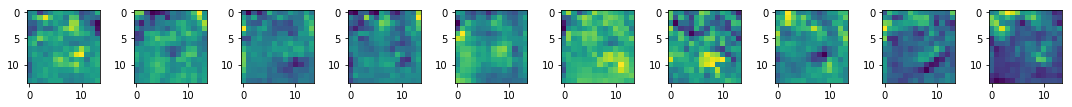

-------------------------------------------------------------------------------------------------------------------------------
Module: MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
Output size( 128x12x12 ): 18432     Time: 0.0005826950073242188
-------------------------------------------------------------------------------------------------------------------------------


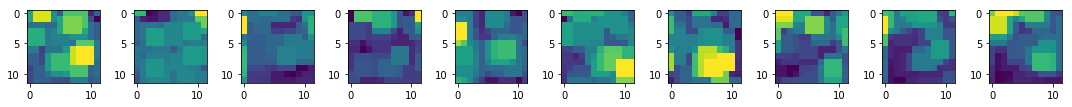

-------------------------------------------------------------------------------------------------------------------------------
Module: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Output size( 128x12x12 ): 18432     Time: 0.002328634262084961
-------------------------------------------------------------------------------------------------------------------------------


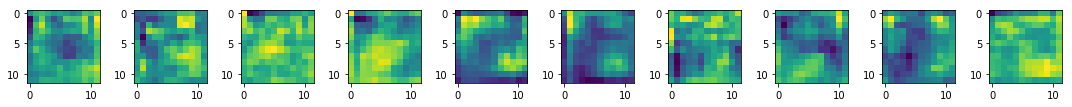

-------------------------------------------------------------------------------------------------------------------------------
Module: MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
Output size( 128x10x10 ): 12800     Time: 0.00044345855712890625
-------------------------------------------------------------------------------------------------------------------------------


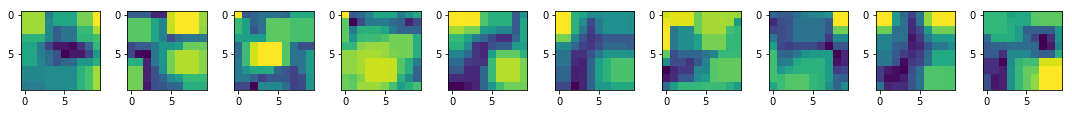

-------------------------------------------------------------------------------------------------------------------------------
Module: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output size( 128x10x10 ): 12800     Time: 0.0004067420959472656
-------------------------------------------------------------------------------------------------------------------------------


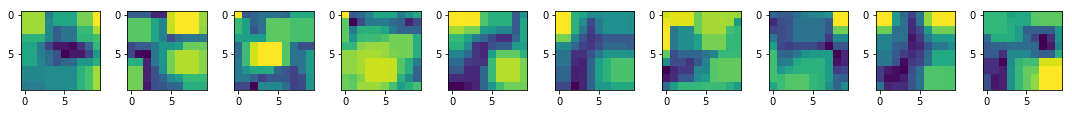

-------------------------------------------------------------------------------------------------------------------------------
Module: LeakyReLU(negative_slope=0.1)
Output size( 128x10x10 ): 12800     Time: 0.00014352798461914062
-------------------------------------------------------------------------------------------------------------------------------


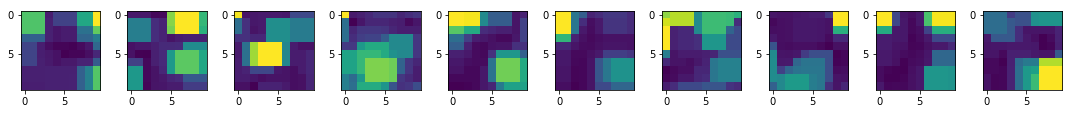

-------------------------------------------------------------------------------------------------------------------------------
Module: AdaptiveAvgPool2d(output_size=8)
Output size( 128x8x8 ): 8192     Time: 0.00029540061950683594
-------------------------------------------------------------------------------------------------------------------------------


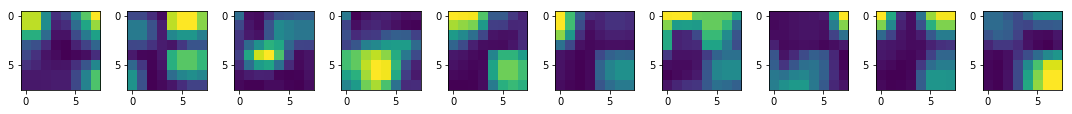

Total time: 0.12033891677856445


In [20]:
image_transforms = get_image_transforms(image_size, trans_type = 'Visualize')
hlp.visualize_model_cnn_output(image_size, model_scratch, image_transforms=image_transforms)   #194-228

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
 
- I took initial model from Lesson-1, 37-Notebook: CNNs for CIFAR Image Classification. I performed around 21 different tests, with 10 epochs and test-accuracy between 10% - 20%. The details of test models used can be seen in models.py. The final model was derived from the test model `Net_21`. All the models stopped improving after 20 epochs.



- The final model takes some inspiration from VGG network.
  - Convolutional and Linear layers are initialzed using kaiming normalization. BatchNorm2d weights are initialized to 1 and bias is initialize to 0.
  - The model has 3 sets of convolutional layers.
  - In each layer, there are 2 convolution operations, 2 max pool operations , 1 Batch normaliztion and in last Leaky ReLU activation.
  - I pass the data to fully-connected layer using `AdaptiveAvgPool2d`.
  - After adding `AdaptiveAvgPool2d` and I removed `Dropout` from the fully-connected layer. I saw improvement in performance from 35% to upto 50%.
  
  
  
- **Learning rate:** I have used [The Cyclical Learning Rate technique](http://teleported.in/posts/cyclic-learning-rate/), which improved the performance while training the model instead of fixed learning rate. I start with a high learning rate, i.e `base_lr = 0.0065` and decreasing to low learning rate upto  `max_lr = 0.004`. As the batch_size is `20`, I reset the learning rate after 20 epochs while training. e.g. when batch_size is `5`:

                Normal Cyclic LR                   Reset Cyclic LR
                --------------------               --------------------
                epoch: 0 Lr:    0.0065               epoch: 0 Lr:    0.0065
                epoch: 1 Lr:     0.006               epoch: 1 Lr:     0.006
                epoch: 2 Lr:    0.0055               epoch: 2 Lr:    0.0055
                epoch: 3 Lr:     0.005               epoch: 3 Lr:     0.005
                epoch: 4 Lr:    0.0045               epoch: 4 Lr:    0.0045
                epoch: 5 Lr:     0.004              [epoch: 5 Lr:    0.0065]
               [epoch: 6 Lr:    0.0045]              epoch: 6 Lr:     0.006
                epoch: 7 Lr:     0.005               epoch: 7 Lr:    0.0055
                epoch: 8 Lr:    0.0055               epoch: 8 Lr:     0.005
                epoch: 9 Lr:     0.006               epoch: 9 Lr:    0.0045
                
   *We can see that incase of `normal Cyclic LR`, after epoch-5, the LR starts increasing, While incase of `Reset Cyclic LR`, after epoch-4, the LR restarts from 0.0065.*  



- Added `np.random.seed(42)`, `torch.backends.cudnn.deterministic = True` and `torch.cuda.manual_seed_all(42)` for consistent training results. But still saw minor differences in the results

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [17]:
import torch.optim as optim

#Ref: http://teleported.in/posts/cyclic-learning-rate/
def get_triangular_lr(iteration, stepsize, base_lr=base_lr, max_lr=max_lr):
    """Given the inputs, calculates the lr that should be applicable for this iteration"""
    cycle = np.floor(1 + iteration/(2  * stepsize))
    x = np.abs(iteration/stepsize - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
    return lr

### TODO: select loss function
#cross_entropy_loss_weights = get_class_weights(data_scratch['train'])
def create_criterion():
    #return nn.CrossEntropyLoss(cross_entropy_loss_weights)
    return nn.CrossEntropyLoss()

### TODO: select optimizer
def create_optimizer(parameters, op_type=optim_type,batch_size=batch_size, epoch=1,base_lr=base_lr, max_lr=max_lr):

    assert op_type == 'SGD' or op_type == 'Adam'
    op_lr = get_triangular_lr(epoch, batch_size, base_lr, max_lr)
    
    if op_type == 'SGD':
        return optim.SGD(parameters,
                                  lr=op_lr, momentum=0.9), op_lr
    elif op_type == 'Adam':
        return optim.Adam(parameters, lr=op_lr), op_lr

In [18]:
criterion_scratch = create_criterion()
optimizer_scratch, lr_scratch = create_optimizer(model_scratch.parameters(), op_type = optim_type)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [19]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(n_epochs, loaders, model, optimizer, lr, criterion, use_cuda, save_path, loss_csv, \
          recs = len(data_scratch['train']), start_epoch=1):
    
    def update_lr(lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    if len(loss_csv)>0:
        valid_loss_min = min(loss_csv['Validation Loss'])
        
    model_test = copy.deepcopy(model)
    # loss trackers
    prev_valid_loss = np.Inf
    prev_train_loss = np.Inf
    
    print('='*106)
    print('|Epoch| Training Loss | Validation Loss | Elapsed Time |      optim     |      Model Status       | Recs |')
    print('='*106)
    
    df_loss = loss_csv
    
    loss_file = 'loss_'+save_path.replace('.pt','')+'.csv'
    
    for epoch in range(start_epoch, n_epochs+1):
        start = time.time()
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # set RNG seeds for python
        np.random.seed(42+ epoch)
        
        # set RNG seeds for pytorch
        if use_cuda:
            torch.backends.cudnn.deterministic = True
            torch.cuda.manual_seed_all(42+ epoch)
        else:
            torch.manual_seed(42+ epoch)

        ###################
        # train the model #
        ###################
        model.train()
        
        """
        To be delete
        ============
        data_images, loaders, _, _, _, _ = load_images(trans_type='Random', dir_seq=(epoch-1)%35)
        recs = len(data_images['train'])
        """
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda() # target.shape: [20(batch-size)]
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            
            optimizer.zero_grad()

            output = model(data) # output.shape: [(batch-size), (classes)]
            
            loss = criterion(output, target)

            loss.backward()

            optimizer.step()
            
            train_loss += loss.item()*data.size(0)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## update the average validation loss

            output = model(data)
            
            loss = criterion(output, target)
            
            valid_loss += loss.item()*data.size(0)
            
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        end=time.time()
        elapsed = end - start


        ## TODO: save the model if validation loss has decreased
        model_status=''
        
        loss_min_reduced = valid_loss < valid_loss_min
        
        if loss_min_reduced:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            model_status='Model saved'
            
        train_loss_increased = train_loss > prev_train_loss
        valid_loss_increased = valid_loss > prev_valid_loss
        train_loss_reduced = train_loss < prev_train_loss
        valid_loss_reduced = valid_loss < prev_valid_loss
        
        
        curr_overfitting = (train_loss < valid_loss)
        curr_underfit = train_loss_increased  and valid_loss_increased
        
        if curr_overfitting:
            if model_status == '':
                model_status = 'Model overfitting'
            else:
                model_status = model_status + '(overfitting)'
        
        if curr_underfit and not curr_overfitting:
            if model_status == '':
                model_status = 'Model underfitting'
            else:
                model_status = model_status + '(underfitting)'
                
        prev_valid_loss = valid_loss
        prev_train_loss = train_loss
        
        # print training/validation statistics     
        df_loss.loc[epoch]=[optim_type, train_loss, valid_loss, elapsed, lr, model_status, recs]
        
        print('|{}|{}|{}|{}|{}|{}|{}|'.format(str(epoch).rjust(5),str(round(train_loss,10)).rjust(15),\
                                str(round(valid_loss,10)).rjust(17),str(round(elapsed,5)).rjust(14),\
                                (str(round(lr,8))+'('+optim_type+')').rjust(16) ,model_status.rjust(25),\
                                str(recs).rjust(6)))
        
        lr = get_triangular_lr((epoch+1)%(batch_size+1), batch_size, base_lr, max_lr)
        update_lr(lr)
         
            
        df_loss.to_csv(loss_file, sep='\t')
        
    print('='*106)
    # return trained model
    return model, df_loss

In [27]:
loss_csv = pd.DataFrame(columns=['optim','Training Loss','Validation Loss','Elapsed Time','lr','Model Saved','Recs'])

model, df_loss = train(100, loaders_scratch, model_scratch, optimizer_scratch, lr_scratch, \
                    criterion_scratch, use_cuda, model_scratch_save_path, loss_csv=loss_csv)

|Epoch| Training Loss | Validation Loss | Elapsed Time |      optim     |      Model Status       | Recs |
|    1|   4.8530209564|     4.7013415005|     580.39125|  0.006375(Adam)|              Model saved|  6680|
|    2|   4.6997165366|     4.5096983396|     119.61359|   0.00625(Adam)|              Model saved|  6680|
|    3|   4.5963980995|     4.4304655269|     120.47658|  0.006125(Adam)|              Model saved|  6680|
|    4|   4.5461586678|     4.8487294734|     120.94482|     0.006(Adam)|        Model overfitting|  6680|
|    5|   4.4735195401|     4.4487821556|     121.06696|  0.005875(Adam)|                         |  6680|
|    6|   4.4166680267|     4.2778285906|     118.89803|   0.00575(Adam)|              Model saved|  6680|
|    7|   4.3571332372|     4.3129356721|     120.16354|  0.005625(Adam)|                         |  6680|
|    8|    4.309038335|     4.0073209123|     119.35664|    0.0055(Adam)|              Model saved|  6680|
|    9|   4.2482140443|     4.0080640

|   74|   2.0966057349|     2.3028399088|     120.92353|  0.005125(Adam)|        Model overfitting|  6680|
|   75|   2.1011108081|     2.1956828411|     121.54729|     0.005(Adam)|        Model overfitting|  6680|
|   76|   2.0612492751|      2.254618936|     121.20402|  0.004875(Adam)|        Model overfitting|  6680|
|   77|   2.0349781859|     2.3050825396|      122.0867|   0.00475(Adam)|        Model overfitting|  6680|
|   78|   2.0742443732|     2.1500680989|     121.74945|  0.004625(Adam)| Model saved(overfitting)|  6680|
|   79|   2.0260388234|     2.2453692231|     121.93913|    0.0045(Adam)|        Model overfitting|  6680|
|   80|   2.0050377318|     2.2173534211|     121.91257|  0.004375(Adam)|        Model overfitting|  6680|
|   81|   1.9735190171|     2.2343079458|     122.30956|   0.00425(Adam)|        Model overfitting|  6680|
|   82|   1.9347136076|     2.1977252246|     122.45941|  0.004125(Adam)|        Model overfitting|  6680|
|   83|   1.9555762166|      2.110137

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [20]:
# test the model
def test(loaders, model, criterion, use_cuda, verbose=True):
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    if use_cuda:
        model.cuda()
        
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            torch.backends.cudnn.deterministic = True
            torch.cuda.manual_seed_all(42)
            data, target = data.cuda(), target.cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    if verbose:    
        print('='*127)
        print('| Loss  |   {}|  Test Accuracy    |  {} |'.format(str(round(test_loss.item(),11)).rjust(16),\
                                (str(100 * correct // total)+ '% ('+ str(correct)+'/'+ str(total)+')').ljust(74)))
        print('='*127)

    return test_loss, correct, total

In [48]:
# load the model that got the best validation accuracy

model_scratch.load_state_dict(torch.load(model_scratch_save_path, map_location='cpu'),strict=False)

# call test function    
test_loss, correct, total = \
    test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

| Loss  |      2.08713316917|  Test Accuracy    |  50.0% (425.0/836.0)                                                        |


### Model Loss

After `61 epochs` the model starts `over-fitting` 

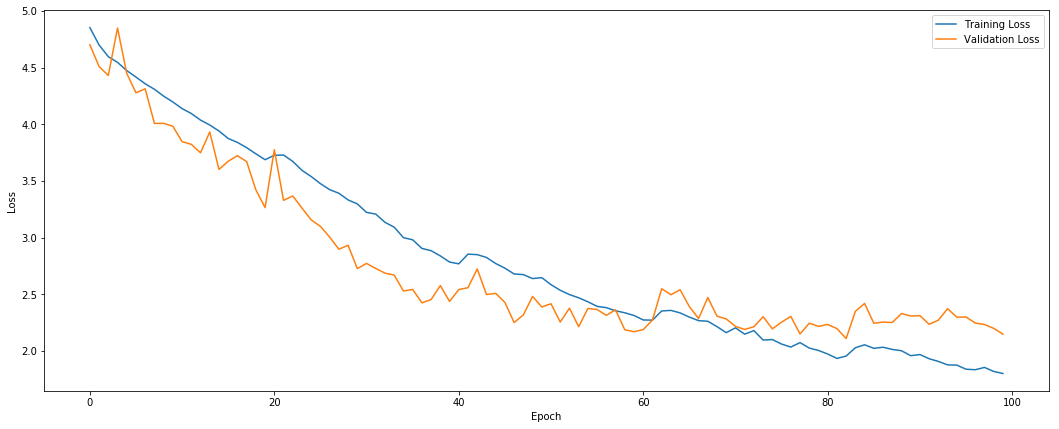

In [21]:
loss_file = 'loss_'+model_scratch_save_path.replace('.pt','')+'.csv'
dfLoss=pd.read_csv(loss_file, '\t')
#log24.columns=['idx','train_loss','valid_loss','elapsed_time','lr_no','model_status']
fig, ax = plt.subplots(figsize=(18,7))
dfLoss['Training Loss'].plot(legend=True, ax=ax);
dfLoss['Validation Loss'].plot(legend=True, ax=ax);
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [21]:
batch_size = 20
base_lr = 0.001 # used by get_triangular_lr for generating learning rate
max_lr = 0.001 # used by get_triangular_lr for generating learning rate
optim_type = 'SGD'
model_transfer_save_path = 'model_transfer.pt'

In [22]:
## TODO: Specify data loaders
data_transfer, loaders_transfer, _, _,_,_ = load_images(batch_size = batch_size,  trans_type='Default')

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [24]:
import torchvision.models as models
import torch.nn as nn
import copy
## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained='imagenet')
for param in model_transfer.parameters():
    param.requires_grad = False

    
model_transfer.fc = nn.Linear(18432, n_classes, bias=True)

fc_parameters = model_transfer.fc.parameters()
for param in fc_parameters:
    param.requires_grad = True
    
print(model_transfer)

if use_cuda:
    model_transfer = model_transfer.cuda()
    
model_test = copy.deepcopy(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

`VGG-16` and `Resnet` are the modern network architecture. 

- `VGG-16` when introduced in 2014 was considered one of the very deep model. It is a very simple architecture, yet very powerful. But is very slow and the weights themselves are very huge.

- Resnet was introduced in 2015, is a Deep residual network, build using micro-architecture modules( also called building blocks). These `Residual blocks` introduced by the authors of Resnet, helped in addressing the model `Degradtion` problem. It is much faster compared to `VGG-16`

- I chose `Resnet50` to build the final CNN architecture for transfer learning. I had to replace the fully connected layer with `Linear(in_features=18432, out_features=133, bias=True)`.

- Also we have to pass fc.parameters to the optimizer as its going to learn the classifier weights.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [25]:
criterion_transfer = create_criterion()

optimizer_transfer, lr_transfer = \
        create_optimizer(model_transfer.fc.parameters(), op_type=optim_type, batch_size=batch_size, epoch=1, base_lr=base_lr, max_lr=max_lr)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [28]:
loss_csv = pd.DataFrame(columns=['optim','Training Loss','Validation Loss','Elapsed Time','lr','Model Saved','Recs'])
model, df_loss = train(10, loaders_transfer, model_transfer, optimizer_transfer, lr_transfer, \
                    criterion_transfer, use_cuda, model_transfer_save_path, loss_csv=loss_csv)

|Epoch| Training Loss | Validation Loss | Elapsed Time |      optim     |      Model Status       | Recs |
|    1|   3.3123717301|     1.1522362878|     241.72031|      0.001(SGD)|              Model saved|  6680|
|    2|   2.1331673331|     0.8409528154|     240.12288|      0.001(SGD)|              Model saved|  6680|
|    3|   1.8778915345|     0.7638587602|     239.84377|      0.001(SGD)|              Model saved|  6680|
|    4|   1.7901200192|     0.6570729558|     240.67556|      0.001(SGD)|              Model saved|  6680|
|    5|   1.6999510514|     0.6624018767|     239.61348|      0.001(SGD)|                         |  6680|
|    6|    1.607799435|     0.6540748715|     240.40346|      0.001(SGD)|              Model saved|  6680|
|    7|   1.5925877116|     0.7006957386|     240.02167|      0.001(SGD)|                         |  6680|
|    8|   1.5690070632|      0.627613989|     240.05568|      0.001(SGD)|              Model saved|  6680|
|    9|   1.5245531787|     0.6227503

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [32]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load(model_transfer_save_path, map_location='cpu'),strict=False)

# call test function    
test_loss, correct, total = \
    test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

| Loss  |      0.62032663822|  Test Accuracy    |  81.0% (678.0/836.0)                                                        |


### Model Loss

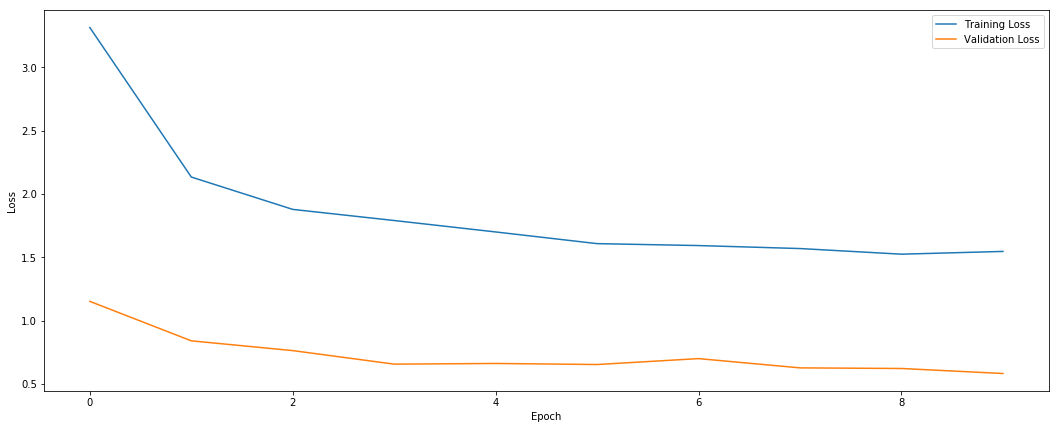

In [40]:
loss_file = 'loss_'+model_transfer_save_path.replace('.pt','')+'.csv'
dfLoss=pd.read_csv(loss_file, '\t')
#log24.columns=['idx','train_loss','valid_loss','elapsed_time','lr_no','model_status']
fig, ax = plt.subplots(figsize=(18,7))
dfLoss['Training Loss'].plot(legend=True, ax=ax);
dfLoss['Validation Loss'].plot(legend=True, ax=ax);
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()
model_transfer.load_state_dict(torch.load(model_transfer_save_path, map_location='cpu'),strict=False)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [26]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from PIL import Image
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path, model, use_cuda):

    image = Image.open(img_path).convert('RGB')
    
    out_size = math.floor(image_size*0.9)
    
    test_transforms = get_image_transforms(image_size, trans_type=None)
    image_transform = transforms.Compose(np.array(test_transforms))
    
    data = image_transform(image)
    
    data = data.unsqueeze_(0)
    
    if use_cuda:
        data = data.cuda()
    
    model.eval()
    
    output = model(data)
    
    probas = F.softmax(output.data.cpu(), dim=1)*100
    
    return probas

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [51]:
def get_embeded_image(img_path):
    data_uri = base64.b64encode(open(img_path, 'rb').read()).decode('utf-8').replace('\n', '')
    return '<img src="data:image/png;base64,{0}" height=350 width=250>'.format(data_uri)
    
def ShowResult(name_from_file, imagenet_label, human_name, dog_detected, breed, breed_strenght, probas, img_path):
    human_face_detected = '{}'.format(human_name is not None)
    human_name = '{}'.format(human_name if human_name is not None else '-')
    dog_detected = '{}'.format(dog_detected)
    dog_breed = '{}{}'.format(breed if breed is not None else '-', \
                                   '( '+str(breed_strenght)+'% )' if breed is not None else '')
    
    row_start = '<tr><td><font size="3">'
    row_middle = '</font></td><td><b><font size="3"><p style="text-align:left;">'
    row_end = '</p></font></b></td></tr>'
    
    display(HTML('<table><tr><td width="60%"><table>\
    <tr><td colspan="2" ><h1 style="text-align:center;"><b>'+name_from_file.ljust(50, ' ')+'</b></h1></td></tr>\
    '+row_start+'Imagenet Label:' + row_middle + imagenet_label + row_end +'\
    '+row_start+'Face Detected:' + row_middle + human_face_detected + row_end +'\
    '+row_start+'Name: ' + row_middle + human_name + row_end +'\
    '+row_start+'Dog Detected: ' + row_middle + dog_detected + row_end +'\
    '+row_start+'Breed: ' + row_middle + dog_breed + row_end +'\
    </td></tr></table></td><td width="40%">' + get_embeded_image(img_path) + '</td></tr></table>'))

In [52]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def process_face_detector(img_path):
    
    face_detected = face_detector(img_path)
    
    name = None
    
    if face_detected:
        name = hlp.get_name_from_filename(img_path)
        
    return name

def process_dog_detector(img_path):
    
    dog_detected = dog_detector(img_path)
    
    breed = None
    breed_strenght = None
    probas = None
    if dog_detected:
        model_transfer.load_state_dict(torch.load(model_transfer_save_path, map_location='cpu'),strict=False)
        probas = predict_breed_transfer(img_path, model_transfer, use_cuda)
        breed = class_names[probas.argmax()]
        breed_strenght = round(probas.max().item(),0)
        
    return dog_detected, breed, breed_strenght, probas

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    name_from_file = hlp.get_name_from_filename(img_path)
    
    imagenet_label = predict_imagenet_class_label(img_path)
    
    human_name = process_face_detector(img_path)
    
    dog_detected, breed, breed_strenght, probas = process_dog_detector(img_path)
    
    ShowResult(name_from_file, imagenet_label, human_name, dog_detected, breed, breed_strenght, probas, img_path)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__


- 1. Fine tune the resnet transfer learning model, by trying different optimizers and learning rates. Currently used only `SGD` with `Lr=0.001`. Also should test the performane using `F1/F2-scores`


- 2. Even the data used in transfer learning was not balanced. Add more sample augmented images, using `openCV`, `imgaug`, `skimage`

- 3. Also try other pre-trained architectures like `Inception v3`,`ResNet-152`, `VGG-19`


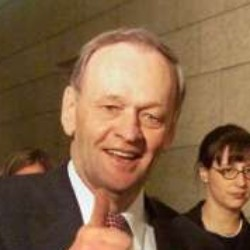


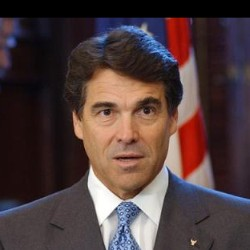


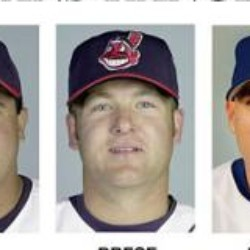


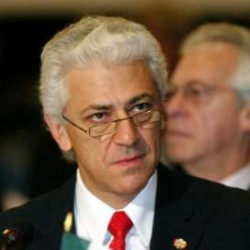


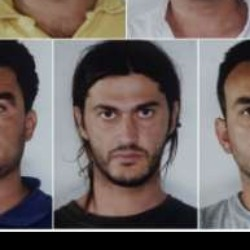


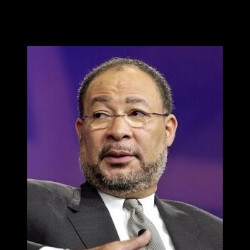


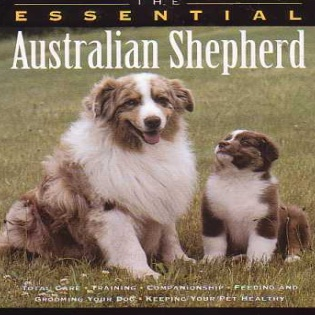


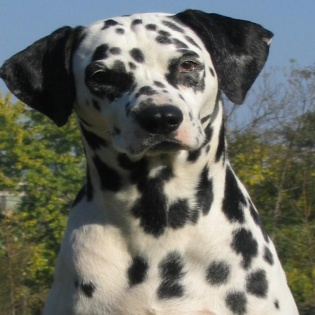


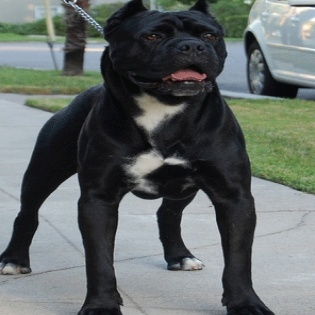


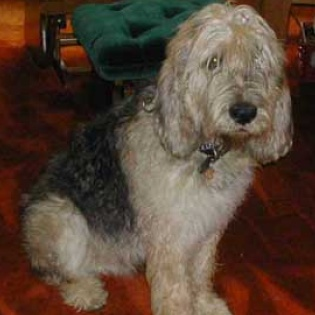


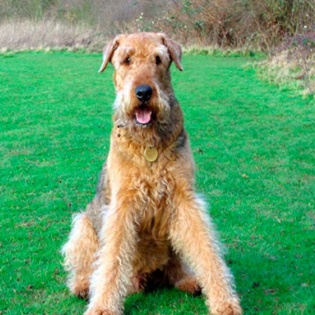


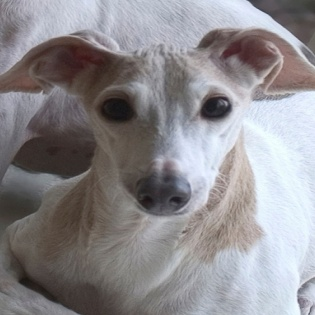

In [53]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
##
## suggested code, below
human_samples = random.sample(range(0, len(human_files)-1), 6)
dog_samples = random.sample(range(0, len(dog_files)-1), 6)
for file in np.hstack((human_files[human_samples], dog_files[dog_samples])):
    run_app(file)